In [1]:
import numpy as np
import pickle
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectPercentile, chi2
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score,roc_auc_score,recall_score
import pandas as pd
import json

In [10]:
df = pd.read_parquet('raw_train.parquet')



0    41785
1    18215
Name: label, dtype: int64


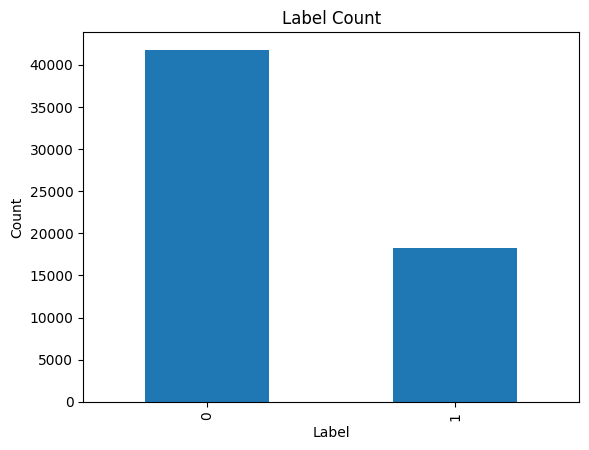

In [20]:
label_counts = df['label'].value_counts()
print(label_counts)
# Plot biểu đồ cột
label_counts.plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label Count')
plt.show()

In [12]:
X=df.drop('label',axis=1)
Y=df['label']
print(X.dtypes)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

feature1     object
feature2     object
feature3     object
feature4     object
feature5     object
feature6     object
feature7     object
feature8     object
feature9     object
feature10    object
feature11    object
feature12    object
feature13    object
feature14    object
feature15    object
feature16    object
feature17    object
feature18    object
feature19    object
feature20    object
dtype: object


In [11]:
categorical_features = ['feature2', 'feature5','feature8','feature11','feature13','feature16','feature18']

# Convert real number values to strings in categorical features
df[categorical_features] = df[categorical_features].astype(str)
print(df.dtypes)

feature1     object
feature2     object
feature3     object
feature4     object
feature5     object
feature6     object
feature7     object
feature8     object
feature9     object
feature10    object
feature11    object
feature12    object
feature13    object
feature14    object
feature15    object
feature16    object
feature17    object
feature18    object
feature19    object
feature20    object
label         int64
dtype: object


In [36]:
label_counts_test = Y_test.value_counts()
print(label_counts_test)

0    4215
1    1785
Name: label, dtype: int64


In [39]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(random_state=0,scale_pos_weight=3)

xgb_model.fit(X_train, Y_train)


Y_pred_xgb = xgb_model.predict(X_test)
print("auc_score",roc_auc_score(Y_test,Y_pred_xgb))
print('f1_score',f1_score(Y_test,Y_pred_xgb))
print("recall",recall_score(Y_test,Y_pred_xgb))

auc_score 0.7831424384700498
f1_score 0.6797633136094675
recall 0.8044817927170869


In [35]:
filename = 'prob_2.ckpt'
pickle.dump(xgb_model, open(filename, 'wb'))

In [8]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [15]:
from catboost import CatBoostClassifier

clf = CatBoostClassifier(
    # iterations=100,
    # random_seed=42,
    # custom_loss=['AUC', 'Recall'],
    # verbose=False,
    # random_state=0,
    # scale_pos_weight=3
)


clf.fit(
    X_train, Y_train,
    cat_features=cat_features,
    eval_set=(X_test, Y_test),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [16]:
Y_pred_cb = clf.predict(X_test)
print("auc_score",roc_auc_score(Y_test,Y_pred_cb))
print("f1_score",f1_score(Y_pred_cb,Y_test))
print("recall",recall_score(Y_pred_cb,Y_test))

auc_score 0.736280989264033
f1_score 0.6332814930015551
recall 0.7118881118881119


In [62]:
from lightgbm import LGBMClassifier
lgbmc_model=LGBMClassifier(random_state=0,scale_pos_weight=3)
lgbmc_model.fit(X_train, Y_train,categorical_feature = 'auto',eval_set=(X_val, Y_val),feature_name='auto', verbose=0)

Y_pred_lgbmc = lgbmc_model.predict(X_test)
print("auc_score",roc_auc_score(Y_test,Y_pred_lgbmc))
print('f1_score',f1_score(Y_test,Y_pred_lgbmc))
print("recall",recall_score(Y_test,Y_pred_lgbmc))

/home/minh/miniconda3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


auc_score 0.7822642224149446
f1_score 0.6749547920433996
recall 0.8364145658263306


In [64]:
filename = 'prob_2.ckpt'
pickle.dump(lgbmc_model, open(filename, 'wb'))

In [73]:
with open('features_config.json', 'r') as f:
    features_config = json.load(f)
features_config

{'numeric_columns': ['feature2', 'feature5', 'feature13', 'feature18'],
 'category_columns': ['feature1',
  'feature3',
  'feature4',
  'feature6',
  'feature7',
  'feature8',
  'feature9',
  'feature10',
  'feature11',
  'feature12',
  'feature14',
  'feature15',
  'feature16',
  'feature17',
  'feature19',
  'feature20'],
 'target_column': 'label',
 'ml_type': 'classification'}

In [74]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler()),
           ('pca', PCA())
           ]
)
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
        # ("selector", SelectPercentile(chi2, percentile=50)),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, features_config['numeric_columns']),
        ("cat", categorical_transformer, features_config['category_columns']),
    ]
)

In [82]:
clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("model", LGBMClassifier(random_state=0,scale_pos_weight=2.5))]
)


In [83]:
clf.fit(X_train, Y_train)

Y_pred_lgbmc = clf.predict(X_test)
print("auc_score",roc_auc_score(Y_test,Y_pred_lgbmc))
print('f1_score',f1_score(Y_test,Y_pred_lgbmc))
print("recall",recall_score(Y_test,Y_pred_lgbmc))

auc_score 0.7801768394190416
f1_score 0.6757647058823529
recall 0.8044817927170869


In [ ]:
filename = 'prob_2.ckpt'
pickle.dump(clf, open(filename, 'wb'))